<a href="https://colab.research.google.com/github/Vikas-KM/quora-question-pair/blob/main/solving_quora_question_pair.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/quora-question-pairs/train.csv.zip
/kaggle/input/quora-question-pairs/sample_submission.csv.zip
/kaggle/input/quora-question-pairs/test.csv
/kaggle/input/quora-question-pairs/test.csv.zip


In [ ]:
import zipfile

import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

In [ ]:
import math

In [ ]:
zf = zipfile.ZipFile('/kaggle/input/quora-question-pairs/train.csv.zip')
df_train = pd.read_csv(zf.open('train.csv'))
df_train.head()

,id,qid1,qid2,question1,question2,is_duplicate
0,0,1,2,What is the step by step guide to invest in sh...,What is the step by step guide to invest in sh...,0
1,1,3,4,What is the story of Kohinoor (Koh-i-Noor) Dia...,What would happen if the Indian government sto...,0
2,2,5,6,How can I increase the speed of my internet co...,How can Internet speed be increased by hacking...,0
3,3,7,8,Why am I mentally very lonely? How can I solve...,Find the remainder when [math]23^{24}[/math] i...,0
4,4,9,10,"Which one dissolve in water quikly sugar, salt...",Which fish would survive in salt water?,0


### Examples of duplicate examples

In [ ]:
# change the index of iloc to see different questions to get and idea
df1 = df_train[df_train['is_duplicate'] == 0]
df2 = df_train[df_train['is_duplicate'] == 1]

qstn1 = df1.iloc[0]['question1']
qstn2 = df1.iloc[0]['question2']
is_dup1 = df1.iloc[0]['is_duplicate']

qstn3 = df2.iloc[0]['question1']
qstn4 = df2.iloc[0]['question2']
is_dup2 = df2.iloc[0]['is_duplicate']


print(qstn1)
print(qstn2)
print('are they duplicates? ', is_dup1)

print(qstn3)
print(qstn4)
print('are they duplicates? ', is_dup2)

What is the step by step guide to invest in share market in india?
What is the step by step guide to invest in share market?
are they duplicates?  0
Astrology: I am a Capricorn Sun Cap moon and cap rising...what does that say about me?
I'm a triple Capricorn (Sun, Moon and ascendant in Capricorn) What does this say about me?
are they duplicates?  1


## basic analysis on the train data

In [ ]:
# how many data points
df_train.shape

(404290, 6)

In [ ]:
# names of the columns
df_train.columns

Index(['id', 'qid1', 'qid2', 'question1', 'question2', 'is_duplicate'], dtype='object')

In [ ]:
# how is data spread, finding the balance/imbalance of the data
df_train['is_duplicate'].value_counts()

0    255027
1    149263
Name: is_duplicate, dtype: int64

In [ ]:
# any null values present
df_train.isna().sum()

id              0
qid1            0
qid2            0
question1       1
question2       2
is_duplicate    0
dtype: int64

In [ ]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 404290 entries, 0 to 404289
Data columns (total 6 columns):
 #   Column        Non-Null Count   Dtype 
---  ------        --------------   ----- 
 0   id            404290 non-null  int64 
 1   qid1          404290 non-null  int64 
 2   qid2          404290 non-null  int64 
 3   question1     404289 non-null  object
 4   question2     404288 non-null  object
 5   is_duplicate  404290 non-null  int64 
dtypes: int64(4), object(2)
memory usage: 18.5+ MB


In [ ]:
print('{}% of duplicate pairs of question'.format(round(df_train['is_duplicate'].mean()*100,2)))

36.92% of duplicate pairs of question


## Exploratory Data Analysis

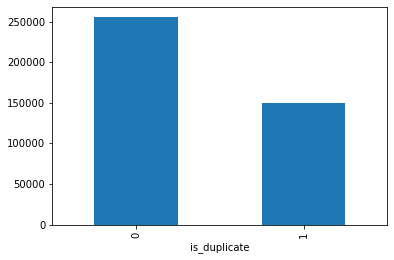

In [ ]:
# count of duplicate and not duplicate questions
df_train.groupby('is_duplicate')['id'].count().plot.bar()


### references
- https://datatofish.com/convert-pandas-dataframe-to-list/
- https://queirozf.com/entries/pandas-dataframe-examples-duplicated-data

In [ ]:
df_train['qid1'].value_counts()

8461      50
14110     48
25984     47
20628     47
1749      47
          ..
415339     1
411241     1
413288     1
409190     1
524288     1
Name: qid1, Length: 290654, dtype: int64

In [ ]:
df_train['qid2'].value_counts()

30782     120
2559      115
4044      100
2561       71
17978      66
         ... 
99475       1
105616      1
85130       1
525311      1
288755      1
Name: qid2, Length: 299364, dtype: int64

### Observations
- Some qids are repeated, that means few questions are repeating

In [ ]:
# number of unique questions
qids = pd.Series(df_train['qid1'].tolist() + df_train['qid2'].tolist())
total_qstns = len(qids)
unique_qstns = len(np.unique(qids))
repeated_qstns = np.sum(qids.value_counts() >1)
print('Total number of questions ',total_qstns)
print('Total number of uniques questions ',unique_qstns)
print('Total number of repeated questions',repeated_qstns)

Total number of questions  808580
Total number of uniques questions  537933
Total number of repeated questions 111780


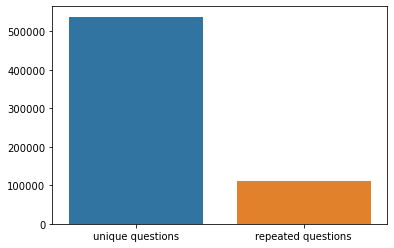

In [ ]:
x=['unique questions', 'repeated questions']
y=[unique_qstns, repeated_qstns]
sns.barplot(x, y)

In [ ]:
# how many times questions are repeated max?
qids.value_counts().iloc[:10]

2559     157
30782    120
4044     111
2561      88
14376     79
17978     77
2675      68
28764     66
1772      63
24555     61
dtype: int64

Text(0, 0.5, 'Number of questions')

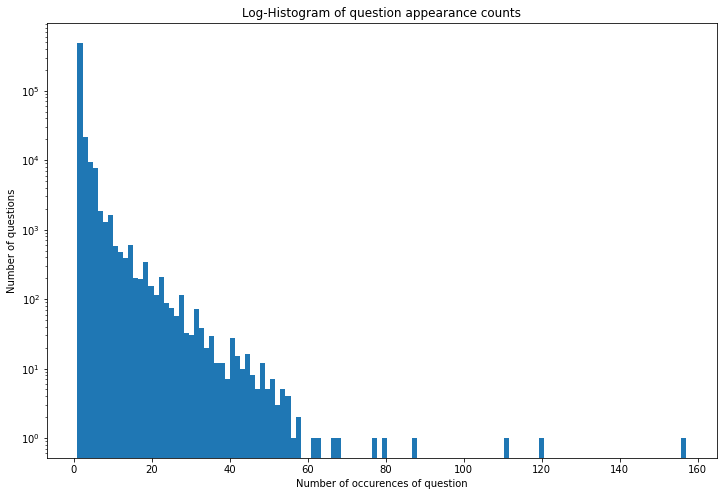

In [ ]:
# questions are in huge numbers so taking logscale for y axis
# nonposy=clip mean negative of log not defined so here a small value is taken

plt.figure(figsize=(12, 8))
plt.hist(qids.value_counts(), bins=120)
plt.yscale('log', nonposy='clip')
plt.title('Log-Histogram of question appearance counts')
plt.xlabel('Number of occurences of question')
plt.ylabel('Number of questions')

### Observations
- As from the above plot we can see, there is a question that is repeated 157, 120, 111 times
( see the above plot query for 157 number)

In [ ]:
df_train.isna().sum()

id              0
qid1            0
qid2            0
question1       1
question2       2
is_duplicate    0
dtype: int64

In [ ]:
# finding rows that have NaN values
df_train[df_train.isna().any(1)]

,id,qid1,qid2,question1,question2,is_duplicate
105780,105780,174363,174364,How can I develop android app?,NaN,0
201841,201841,303951,174364,How can I create an Android app?,NaN,0
363362,363362,493340,493341,NaN,My Chinese name is Haichao Yu. What English na...,0


### Observations
- There are 3 rows which have NaN value
    - we can delete those rows
    - we can fill them with a empty string
    
   
Since the NaN value are only 3 we will discard/drop them

### references
- https://stackoverflow.com/questions/13851535/how-to-delete-rows-from-a-pandas-dataframe-based-on-a-conditional-expression
- https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.DataFrame.dropna.html

In [ ]:
# droping the NaN values
df_train.dropna(axis=0, how='any', inplace=True)

In [ ]:
df_train[df_train.isna().any(1)]

,id,qid1,qid2,question1,question2,is_duplicate


In [ ]:
df_train.isna().sum()

id              0
qid1            0
qid2            0
question1       0
question2       0
is_duplicate    0
dtype: int64

In [ ]:
df_train.shape

(404287, 6)

In [ ]:
## Checking if any pair is duplicate
dup = df_train[['qid1','qid2','is_duplicate']].groupby(['qid1','qid2']).count().reset_index()
df_train.shape[0] - dup.shape[0]

0

### Naive Submission

In [ ]:
from sklearn.metrics import log_loss

p = df_train['is_duplicate'].mean() # Our predicted probability
print('Predicted score:', log_loss(df_train['is_duplicate'], np.zeros_like(df_train['is_duplicate']) + p))

# zf = zipfile.ZipFile('/kaggle/input/quora-question-pairs/test.csv.zip')
# df_test = pd.read_csv(zf.open('test.csv'))

df_test = pd.read_csv('/kaggle/input/quora-question-pairs/test.csv')
sub = pd.DataFrame({'test_id': df_test['test_id'], 'is_duplicate': p})
sub.to_csv('naive_submission.csv', index=False)
sub.head()


Predicted score: 0.658528851473067


,test_id,is_duplicate
0,0,0.369201
1,1,0.369201
2,2,0.369201
3,3,0.369201
4,4,0.369201


In [ ]:
df = pd.read_csv('./naive_submission.csv')
df.shape

(2345796, 2)

## Feature Engineering

### Lets create a few new Features
- **freq_qid1, freq_qid2** -> Frequency count of the qids
- **qlen1, qlen2** -> Length of the question

- **q1_words, q2_words** -> Number of words in the question

In [ ]:
# copying the df_train to df
df = df_train.copy()
df.head()

,id,qid1,qid2,question1,question2,is_duplicate
0,0,1,2,What is the step by step guide to invest in sh...,What is the step by step guide to invest in sh...,0
1,1,3,4,What is the story of Kohinoor (Koh-i-Noor) Dia...,What would happen if the Indian government sto...,0
2,2,5,6,How can I increase the speed of my internet co...,How can Internet speed be increased by hacking...,0
3,3,7,8,Why am I mentally very lonely? How can I solve...,Find the remainder when [math]23^{24}[/math] i...,0
4,4,9,10,"Which one dissolve in water quikly sugar, salt...",Which fish would survive in salt water?,0


### References
- https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.DataFrame.transform.html
- https://pbpython.com/pandas_transform.html

In [ ]:
# using pandas transform to count the frequency of the qstn based on qid
df['freq_qid1'] = df.groupby('qid1')['qid1'].transform('count')
df['freq_qid2'] = df.groupby('qid2')['qid2'].transform('count')
df.head()

,id,qid1,qid2,question1,question2,is_duplicate,freq_qid1,freq_qid2
0,0,1,2,What is the step by step guide to invest in sh...,What is the step by step guide to invest in sh...,0,1,1
1,1,3,4,What is the story of Kohinoor (Koh-i-Noor) Dia...,What would happen if the Indian government sto...,0,4,1
2,2,5,6,How can I increase the speed of my internet co...,How can Internet speed be increased by hacking...,0,1,1
3,3,7,8,Why am I mentally very lonely? How can I solve...,Find the remainder when [math]23^{24}[/math] i...,0,1,1
4,4,9,10,"Which one dissolve in water quikly sugar, salt...",Which fish would survive in salt water?,0,3,1


In [ ]:
# finding the length of the qstn and creating a new feature
df['qlen1'] = df['question1'].apply(lambda x:len(x))
df['qlen2'] = df['question2'].apply(lambda x:len(x))
df.head()

,id,qid1,qid2,question1,question2,is_duplicate,freq_qid1,freq_qid2,qlen1,qlen2
0,0,1,2,What is the step by step guide to invest in sh...,What is the step by step guide to invest in sh...,0,1,1,66,57
1,1,3,4,What is the story of Kohinoor (Koh-i-Noor) Dia...,What would happen if the Indian government sto...,0,4,1,51,88
2,2,5,6,How can I increase the speed of my internet co...,How can Internet speed be increased by hacking...,0,1,1,73,59
3,3,7,8,Why am I mentally very lonely? How can I solve...,Find the remainder when [math]23^{24}[/math] i...,0,1,1,50,65
4,4,9,10,"Which one dissolve in water quikly sugar, salt...",Which fish would survive in salt water?,0,3,1,76,39


In [ ]:
# number of words in the questions
df['q1_words'] = df['question1'].apply(lambda x: len(x.split(' ')))
df['q2_words'] = df['question2'].apply(lambda x: len(x.split(' ')))
df.head()

,id,qid1,qid2,question1,question2,is_duplicate,freq_qid1,freq_qid2,qlen1,qlen2,q1_words,q2_words
0,0,1,2,What is the step by step guide to invest in sh...,What is the step by step guide to invest in sh...,0,1,1,66,57,14,12
1,1,3,4,What is the story of Kohinoor (Koh-i-Noor) Dia...,What would happen if the Indian government sto...,0,4,1,51,88,8,13
2,2,5,6,How can I increase the speed of my internet co...,How can Internet speed be increased by hacking...,0,1,1,73,59,14,10
3,3,7,8,Why am I mentally very lonely? How can I solve...,Find the remainder when [math]23^{24}[/math] i...,0,1,1,50,65,11,9
4,4,9,10,"Which one dissolve in water quikly sugar, salt...",Which fish would survive in salt water?,0,3,1,76,39,13,7


### References
- https://stackoverflow.com/questions/11938964/how-to-find-common-words-and-print-them-using-python-command/12136296

    - common = set(document_1_words).intersection( set(document_2_words) )
    - unique = set(document_1_words).symmetric_difference( set(document_2_words) )
    
    
- **common_words** -> common words to question1 and question2
- **total_words** -> total unique words to belonging to both question1 and question2
- **share_words** -> the share words is defined as common words divided by total words

In [ ]:
# common words to both qstn1 and qstn2 
def word_common(row):
        w1 = set(map(lambda word: word.lower().strip(), row['question1'].split(" ")))
        w2 = set(map(lambda word: word.lower().strip(), row['question2'].split(" ")))
        return len(w1.intersection(w2))
df['common_words'] = df.apply(word_common, axis=1)

df.head()

,id,qid1,qid2,question1,question2,is_duplicate,freq_qid1,freq_qid2,qlen1,qlen2,q1_words,q2_words,common_words
0,0,1,2,What is the step by step guide to invest in sh...,What is the step by step guide to invest in sh...,0,1,1,66,57,14,12,10
1,1,3,4,What is the story of Kohinoor (Koh-i-Noor) Dia...,What would happen if the Indian government sto...,0,4,1,51,88,8,13,4
2,2,5,6,How can I increase the speed of my internet co...,How can Internet speed be increased by hacking...,0,1,1,73,59,14,10,4
3,3,7,8,Why am I mentally very lonely? How can I solve...,Find the remainder when [math]23^{24}[/math] i...,0,1,1,50,65,11,9,0
4,4,9,10,"Which one dissolve in water quikly sugar, salt...",Which fish would survive in salt water?,0,3,1,76,39,13,7,2


In [ ]:
# Total words of both qstn1 and qstn2 
def word_total(row):
        w1 = set(map(lambda word: word.lower().strip(), row['question1'].split(" ")))
        w2 = set(map(lambda word: word.lower().strip(), row['question2'].split(" ")))
        return len(w1)+len(w2)
df['total_words'] = df.apply(word_total, axis=1)

df.head()

,id,qid1,qid2,question1,question2,is_duplicate,freq_qid1,freq_qid2,qlen1,qlen2,q1_words,q2_words,common_words,total_words
0,0,1,2,What is the step by step guide to invest in sh...,What is the step by step guide to invest in sh...,0,1,1,66,57,14,12,10,23
1,1,3,4,What is the story of Kohinoor (Koh-i-Noor) Dia...,What would happen if the Indian government sto...,0,4,1,51,88,8,13,4,20
2,2,5,6,How can I increase the speed of my internet co...,How can Internet speed be increased by hacking...,0,1,1,73,59,14,10,4,24
3,3,7,8,Why am I mentally very lonely? How can I solve...,Find the remainder when [math]23^{24}[/math] i...,0,1,1,50,65,11,9,0,19
4,4,9,10,"Which one dissolve in water quikly sugar, salt...",Which fish would survive in salt water?,0,3,1,76,39,13,7,2,20


In [ ]:
# words shared between of both qstn1 and qstn2 
# gives us an idea as to how similar the two qstns maybe
# higher the share words implies more similar the wordings are of the two sentences

df['share_words'] = df['common_words']/(df['total_words'])
df.head()

,id,qid1,qid2,question1,question2,is_duplicate,freq_qid1,freq_qid2,qlen1,qlen2,q1_words,q2_words,common_words,total_words,share_words
0,0,1,2,What is the step by step guide to invest in sh...,What is the step by step guide to invest in sh...,0,1,1,66,57,14,12,10,23,0.434783
1,1,3,4,What is the story of Kohinoor (Koh-i-Noor) Dia...,What would happen if the Indian government sto...,0,4,1,51,88,8,13,4,20,0.200000
2,2,5,6,How can I increase the speed of my internet co...,How can Internet speed be increased by hacking...,0,1,1,73,59,14,10,4,24,0.166667
3,3,7,8,Why am I mentally very lonely? How can I solve...,Find the remainder when [math]23^{24}[/math] i...,0,1,1,50,65,11,9,0,19,0.000000
4,4,9,10,"Which one dissolve in water quikly sugar, salt...",Which fish would survive in salt water?,0,3,1,76,39,13,7,2,20,0.100000


- **freq_q1+freq_q2** = sum total of frequency of qid1 and qid2
- **freq_q1-freq_q2** = absolute difference of frequency of qid1 and qid2

In [ ]:
df['freq_q1+q2'] = df['freq_qid1'] + df['freq_qid2']
df['freq_q1-q2'] = abs(df['freq_qid1'] - df['freq_qid2'])

### Analysis from the extracted features

In [ ]:
# minimum length of the question1
print('minimum length of the qstn1 is ',min(df['qlen1']))

# minimum length of the question2
print('minimum length of the qstn2 is ',min(df['qlen2']))

minimum length of the qstn1 is  1
minimum length of the qstn2 is  1


In [ ]:
# questions of minimum length
print(df[df['qlen1']== 1].shape[0])
df[df['qlen1']== 1]['question1']

19


3306      .
13016     ?
20794     ?
96725     ?
104101    ?
108978    i
115347    o
134403    ?
151922    o
158778    A
189659    ?
190570    ‘
199110    I
208485    ?
213220    ?
254161    ?
273065    ?
357127    H
402423    ?
Name: question1, dtype: object

In [ ]:
print(df[df['qlen2']== 1].shape[0])
df[df['qlen2']== 1]['question2']

2


47056     ?
198913    o
Name: question2, dtype: object

In [ ]:
df.shape[0]

404287

### Observation
- There are 19 questions of Question1 which has only 1 character
- There are 2 questions of Question2 which has only 1 character

These 21 form a miniscule part(0.005%) of the training, we can drop them

In [ ]:
min(df['q1_words'])

1

In [ ]:
print(df[df['q1_words']== 1].shape[0])
df[df['q1_words']== 1]['question1']
print(df[df['q1_words']== 1]['question1'].value_counts())

66
?            11
deleted       9
Deleted.      5
What?         4
My            2
o             2
Why?          2
A             1
Life:         1
grammar       1
‘             1
delete        1
Which         1
…..           1
hi            1
i             1
How           1
Marriage      1
HH            1
[removed]     1
no            1
civil         1
sss           1
Nana          1
Cloning?      1
Q?            1
111           1
Can?          1
Aaas          1
spam          1
What          1
.             1
I             1
Na            1
H             1
Is?           1
Error         1
Ok            1
Name: question1, dtype: int64


In [ ]:
min(df['q2_words'])

1

In [ ]:
print(df[df['q2_words']== 1].shape[0])
df[df['q2_words']== 1]['question2']
print(df[df['q2_words']== 1]['question2'].value_counts())

22
What?            3
…………..           2
Spam             2
Deleted.         2
????             1
deleted          1
Hh               1
o                1
?                1
Delete           1
Why              1
parisflatlist    1
[removed]        1
HH               1
Does?            1
Edit             1
lol              1
Name: question2, dtype: int64


In [ ]:
df[df['question2']=='Spam']

,id,qid1,qid2,question1,question2,is_duplicate,freq_qid1,freq_qid2,qlen1,qlen2,q1_words,q2_words,common_words,total_words,share_words,freq_q1+q2,freq_q1-q2
236655,236655,153211,347631,Why was spam is called spam?,Spam,0,1,2,28,4,6,1,1,7,0.142857,3,1
361480,361480,491330,347631,"As a 13 year old, how do I get out of my unliv...",Spam,0,1,2,57,4,14,1,0,15,0.000000,3,1


In [ ]:
df[df['question2']=='deleted']

,id,qid1,qid2,question1,question2,is_duplicate,freq_qid1,freq_qid2,qlen1,qlen2,q1_words,q2_words,common_words,total_words,share_words,freq_q1+q2,freq_q1-q2
231313,231313,179756,341088,From where to download episode2 season 3 of Th...,deleted,0,1,1,54,7,10,1,0,11,0.0,2,0


### Observations
- There are 66 and 22 question with one word in question1 and Question2
- bunch of keywords are deleted/delete spam and lol and dots conveying nothing at all

In [ ]:
df['share_words'][0:].head()

0    0.434783
1    0.200000
2    0.166667
3    0.000000
4    0.100000
Name: share_words, dtype: float64

##### Can the share_words be used to see if it will help to separate the given question pairs?

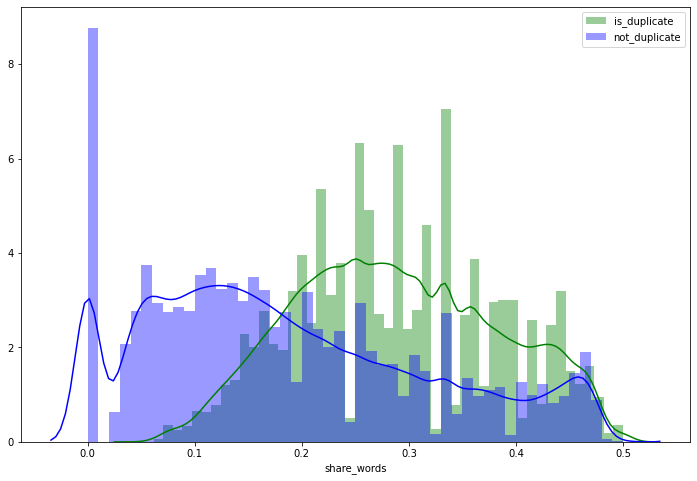

In [ ]:
plt.figure(figsize=(12,8))
sns.distplot(df[df['is_duplicate'] == 1.0]['share_words'], label = "is_duplicate", color = 'green')
sns.distplot(df[df['is_duplicate'] == 0.0]['share_words'], label = "not_duplicate" , color = 'blue' )
plt.legend()
plt.show()

### Observation
- green indicates duplicates, higher share words means they may be duplicates
- blue indicates not duplicates, lower share words means they may not be duplicates

Since there is lot of overlap it is not strict separation as can be seen from the above graph

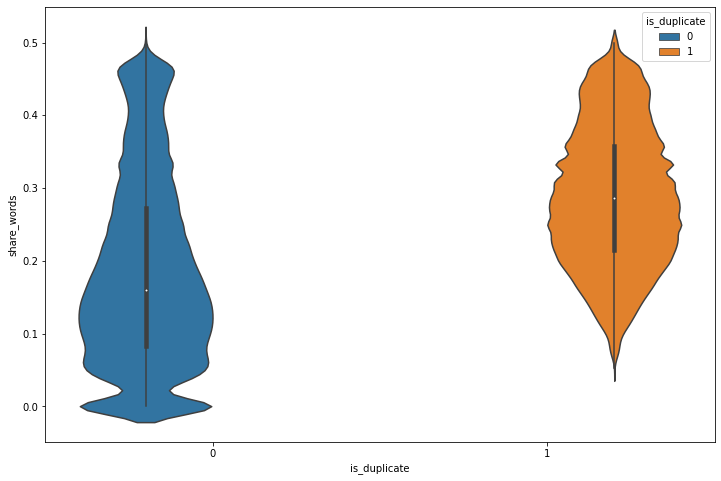

In [ ]:
plt.figure(figsize=(12,8))
x = df['is_duplicate']
y = df['share_words']
sns.violinplot(x,y, hue=df['is_duplicate'])
plt.show()

##### Can the common_words be used to see if it will help to separate the given question pairs?

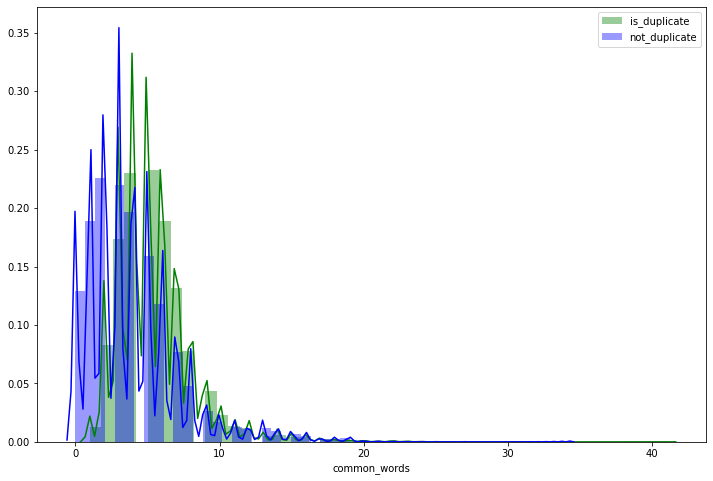

In [ ]:
plt.figure(figsize=(12,8))
sns.distplot(df[df['is_duplicate'] == 1.0]['common_words'], label = "is_duplicate", color = 'green')
sns.distplot(df[df['is_duplicate'] == 0.0]['common_words'], label = "not_duplicate" , color = 'blue' )
plt.legend()
plt.show()

#### Observation:
- too much overlap

## Text Preprocessing

- Removing HTML Tags
- Removing Punctuations
- Removing Numbers
- Performing Stemming
- Removing Stop words etc

In [ ]:
import re

#### Code to remove URL links from text

In [ ]:
# https://stackoverflow.com/questions/11331982/how-to-remove-any-url-within-a-string-in-python/40823105#40823105
def remove_URL(text):
    """Remove URLs from a text string"""
    return re.sub(r"http\S+", "", text)

In [ ]:
df['question1'] = df['question1'].apply(lambda x: remove_URL(x))
df.head()

,id,qid1,qid2,question1,question2,is_duplicate,freq_qid1,freq_qid2,qlen1,qlen2,q1_words,q2_words,common_words,total_words,share_words,freq_q1+q2,freq_q1-q2
0,0,1,2,What is the step by step guide to invest in sh...,What is the step by step guide to invest in sh...,0,1,1,66,57,14,12,10,23,0.434783,2,0
1,1,3,4,What is the story of Kohinoor (Koh-i-Noor) Dia...,What would happen if the Indian government sto...,0,4,1,51,88,8,13,4,20,0.200000,5,3
2,2,5,6,How can I increase the speed of my internet co...,How can Internet speed be increased by hacking...,0,1,1,73,59,14,10,4,24,0.166667,2,0
3,3,7,8,Why am I mentally very lonely? How can I solve...,Find the remainder when [math]23^{24}[/math] i...,0,1,1,50,65,11,9,0,19,0.000000,2,0
4,4,9,10,"Which one dissolve in water quikly sugar, salt...",Which fish would survive in salt water?,0,3,1,76,39,13,7,2,20,0.100000,4,2


In [ ]:
df['question2'] = df['question2'].apply(lambda x: remove_URL(x))
df.head()

,id,qid1,qid2,question1,question2,is_duplicate,freq_qid1,freq_qid2,qlen1,qlen2,q1_words,q2_words,common_words,total_words,share_words,freq_q1+q2,freq_q1-q2
0,0,1,2,What is the step by step guide to invest in sh...,What is the step by step guide to invest in sh...,0,1,1,66,57,14,12,10,23,0.434783,2,0
1,1,3,4,What is the story of Kohinoor (Koh-i-Noor) Dia...,What would happen if the Indian government sto...,0,4,1,51,88,8,13,4,20,0.200000,5,3
2,2,5,6,How can I increase the speed of my internet co...,How can Internet speed be increased by hacking...,0,1,1,73,59,14,10,4,24,0.166667,2,0
3,3,7,8,Why am I mentally very lonely? How can I solve...,Find the remainder when [math]23^{24}[/math] i...,0,1,1,50,65,11,9,0,19,0.000000,2,0
4,4,9,10,"Which one dissolve in water quikly sugar, salt...",Which fish would survive in salt water?,0,3,1,76,39,13,7,2,20,0.100000,4,2


In [ ]:
from bs4 import BeautifulSoup

#### Code to remove tags using beautifulSoup

In [ ]:
# https://stackoverflow.com/questions/16206380/python-beautifulsoup-how-to-remove-all-tags-from-an-element
def getText(x):
    soup = BeautifulSoup(x, 'lxml')
    text = soup.get_text()
    return text

In [ ]:
df['question1'] = df['question1'].apply(lambda x: getText(x))
df.head()

/opt/conda/lib/python3.7/site-packages/bs4/__init__.py:312: UserWarning: "." looks like a filename, not markup. You should probably open this file and pass the filehandle into Beautiful Soup.
  ' Beautiful Soup.' % self._decode_markup(markup)


,id,qid1,qid2,question1,question2,is_duplicate,freq_qid1,freq_qid2,qlen1,qlen2,q1_words,q2_words,common_words,total_words,share_words,freq_q1+q2,freq_q1-q2
0,0,1,2,What is the step by step guide to invest in sh...,What is the step by step guide to invest in sh...,0,1,1,66,57,14,12,10,23,0.434783,2,0
1,1,3,4,What is the story of Kohinoor (Koh-i-Noor) Dia...,What would happen if the Indian government sto...,0,4,1,51,88,8,13,4,20,0.200000,5,3
2,2,5,6,How can I increase the speed of my internet co...,How can Internet speed be increased by hacking...,0,1,1,73,59,14,10,4,24,0.166667,2,0
3,3,7,8,Why am I mentally very lonely? How can I solve...,Find the remainder when [math]23^{24}[/math] i...,0,1,1,50,65,11,9,0,19,0.000000,2,0
4,4,9,10,"Which one dissolve in water quikly sugar, salt...",Which fish would survive in salt water?,0,3,1,76,39,13,7,2,20,0.100000,4,2


In [ ]:
df['question2'] = df['question2'].apply(lambda x: getText(x))
df.head()

,id,qid1,qid2,question1,question2,is_duplicate,freq_qid1,freq_qid2,qlen1,qlen2,q1_words,q2_words,common_words,total_words,share_words,freq_q1+q2,freq_q1-q2
0,0,1,2,What is the step by step guide to invest in sh...,What is the step by step guide to invest in sh...,0,1,1,66,57,14,12,10,23,0.434783,2,0
1,1,3,4,What is the story of Kohinoor (Koh-i-Noor) Dia...,What would happen if the Indian government sto...,0,4,1,51,88,8,13,4,20,0.200000,5,3
2,2,5,6,How can I increase the speed of my internet co...,How can Internet speed be increased by hacking...,0,1,1,73,59,14,10,4,24,0.166667,2,0
3,3,7,8,Why am I mentally very lonely? How can I solve...,Find the remainder when [math]23^{24}[/math] i...,0,1,1,50,65,11,9,0,19,0.000000,2,0
4,4,9,10,"Which one dissolve in water quikly sugar, salt...",Which fish would survive in salt water?,0,3,1,76,39,13,7,2,20,0.100000,4,2


#### Expanding English language contractions in Python

In [ ]:
! pip install contractions

     |████████████████████████████████| 312 kB 878 kB/s eta 0:00:01
  Created wheel for pyahocorasick: filename=pyahocorasick-1.4.0-cp37-cp37m-linux_x86_64.whl size=99070 sha256=4fa40c538310feef42d005bd00c8e1a7417aeb2df0b168911ac5bb51c4a359ff
  Stored in directory: /root/.cache/pip/wheels/9b/6b/f7/62dc8caf183b125107209c014e78c340a0b4b7b392c23c2db4
Successfully built pyahocorasick
You should consider upgrading via the '/opt/conda/bin/python3.7 -m pip install --upgrade pip' command.


In [ ]:
import contractions
print(contractions.fix("i like this and 'll and you've"))
print(contractions.fix("he's"))
print(contractions.fix("'ll"))

i like this and  will and you have
he is
 will


In [ ]:
#https://stackoverflow.com/questions/19790188/expanding-english-language-contractions-in-python/47091490#47091490

def decontracted(phrase):
    # specific
    phrase = re.sub(r"won\'t", "will not", phrase)
    phrase = re.sub(r"can\'t", "can not", phrase)

    # general
    phrase = re.sub(r"n\'t", " not", phrase)
    phrase = re.sub(r"\'re", " are", phrase)
    phrase = re.sub(r"\'s", " is", phrase)
    phrase = re.sub(r"\'d", " would", phrase)
    phrase = re.sub(r"\'ll", " will", phrase)
    phrase = re.sub(r"\'t", " not", phrase)
    phrase = re.sub(r"\'ve", " have", phrase)
    phrase = re.sub(r"\'m", " am", phrase)
    return phrase

In [ ]:
# removing special characters
def remove_spl(x):
    x = re.sub('[^A-Za-z0-9]+', '', x)
    return x

In [ ]:
df.head()

,id,qid1,qid2,question1,question2,is_duplicate,freq_qid1,freq_qid2,qlen1,qlen2,q1_words,q2_words,common_words,total_words,share_words,freq_q1+q2,freq_q1-q2
0,0,1,2,What is the step by step guide to invest in sh...,What is the step by step guide to invest in sh...,0,1,1,66,57,14,12,10,23,0.434783,2,0
1,1,3,4,What is the story of Kohinoor (Koh-i-Noor) Dia...,What would happen if the Indian government sto...,0,4,1,51,88,8,13,4,20,0.200000,5,3
2,2,5,6,How can I increase the speed of my internet co...,How can Internet speed be increased by hacking...,0,1,1,73,59,14,10,4,24,0.166667,2,0
3,3,7,8,Why am I mentally very lonely? How can I solve...,Find the remainder when [math]23^{24}[/math] i...,0,1,1,50,65,11,9,0,19,0.000000,2,0
4,4,9,10,"Which one dissolve in water quikly sugar, salt...",Which fish would survive in salt water?,0,3,1,76,39,13,7,2,20,0.100000,4,2


### Text Preprocessing
- Remove stop words
- remove html tags
- remove punctuations
- Stemming
- Expanding contractions

In [ ]:
import nltk
from nltk.corpus import stopwords
nltk.download('stopwords')
nltk.download('punkt')
stop_words = set(stopwords.words('english'))

[nltk_data] Downloading package stopwords to /usr/share/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /usr/share/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [ ]:
def preprocess(x):
    x = str(x).lower()
    x = contractions.fix(x)
    x = BeautifulSoup(x, 'lxml').get_text()
    x = re.sub('[^A-Za-z0-9]+', ' ', x) 
    return x

## Advanced Feature Extraction
- **Token** - is when a sentence is split on space
- **stop_words** - stop words according to NLTK
- **word** - A token that is not stop word


- **cwc_min** : Ratio of common_word_count to min lenghth of word count of Q1 and Q2
- cwc_min = common_word_count / (min(len(q1_words), len(q2_words))


- **cwc_max** : Ratio of common_word_count to max lenghth of word count of Q1 and Q2
- cwc_max = common_word_count / (max(len(q1_words), len(q2_words))


- **csc_min** : Ratio of common_stop_count to min lenghth of stop count of Q1 and Q2
- csc_min = common_stop_count / (min(len(q1_stops), len(q2_stops))


- **csc_max** : Ratio of common_stop_count to max lenghth of stop count of Q1 and Q2
- csc_max = common_stop_count / (max(len(q1_stops), len(q2_stops))


- **ctc_min** : Ratio of common_token_count to min lenghth of token count of Q1 and Q2
- ctc_min = common_token_count / (min(len(q1_tokens), len(q2_tokens))


- **ctc_max** : Ratio of common_token_count to max lenghth of token count of Q1 and Q2
- ctc_max = common_token_count / (max(len(q1_tokens), len(q2_tokens))


- **last_word_eq** : Check if last word of both questions is equal or not
- last_word_eq = int(q1_tokens[-1] == q2_tokens[-1])


- **first_word_eq** : Check if First word of both questions is equal or not
- first_word_eq = int(q1_tokens[0] == q2_tokens[0])


- **abs_len_diff** : Abs. length difference
- abs_len_diff = abs(len(q1_tokens) - len(q2_tokens))


- **mean_len** : Average Token Length of both Questions
- mean_len = (len(q1_tokens) + len(q2_tokens))/2




- fuzz_ratio : https://github.com/seatgeek/fuzzywuzzy#usage http://chairnerd.seatgeek.com/fuzzywuzzy-fuzzy-string-matching-in-python/


- fuzz_partial_ratio : https://github.com/seatgeek/fuzzywuzzy#usage http://chairnerd.seatgeek.com/fuzzywuzzy-fuzzy-string-matching-in-python/


- token_sort_ratio : https://github.com/seatgeek/fuzzywuzzy#usage http://chairnerd.seatgeek.com/fuzzywuzzy-fuzzy-string-matching-in-python/


- token_set_ratio : https://github.com/seatgeek/fuzzywuzzy#usage 
http://chairnerd.seatgeek.com/fuzzywuzzy-fuzzy-string-matching-in-python/


- **longest_substr_ratio** : Ratio of length longest common substring to min lenghth of token count of Q1 and Q2
- longest_substr_ratio = len(longest common substring) / (min(len(q1_tokens), len(q2_tokens))

- https://stackoverflow.com/questions/29050292/python3-x-list-assignment-index-out-of-range
- https://stackoverflow.com/questions/9272849/beginner-python-set-intersection-error

In [ ]:
SAFE_DIV = 0.0001

def get_token_features(q1,q2):
    features = [0.0]*10
    q1_tokens = q1.split(' ')
    q2_tokens = q2.split(' ')
    q1_words = set([word for word in q1_tokens if word not in stop_words])
    q2_words = set([word for word in q2_tokens if word not in stop_words])
    q1_stops = set([word for word in q1_tokens if word in stop_words])
    q2_stops = set([word for word in q2_tokens if word in stop_words])
    
    common_word_count = len(q1_words.intersection(q2_words))
    common_token_count = len(set(q1_tokens).intersection(set(q2_tokens)))
    common_stop_count = len(q1_stops.intersection(q2_stops))
    
    features[0] = (common_word_count)/(min(len(q1_words), len(q2_words))+ SAFE_DIV)
    features[1] = (common_word_count)/(max(len(q1_words), len(q2_words))+ SAFE_DIV)
    
    features[2] = (common_stop_count)/(min(len(q1_stops), len(q2_stops))+ SAFE_DIV)
    features[3] = (common_stop_count)/(max(len(q1_stops), len(q2_stops))+ SAFE_DIV)
    
    features[4] = (common_token_count)/(min(len(q1_tokens), len(q2_tokens))+ SAFE_DIV)
    features[5] = (common_token_count)/(max(len(q1_tokens), len(q2_tokens))+ SAFE_DIV)
    
    features[6] = int(q1_tokens[0] == q2_tokens[0])
    features[7] = int(q1_tokens[-1] == q2_tokens[-1])
    features[8] = abs(len(q1_tokens) - len(q2_tokens))
    features[9] = (len(q1_tokens) + len(q2_tokens))/2
    
    return features
    
    

In [ ]:
df.columns

Index(['id', 'qid1', 'qid2', 'question1', 'question2', 'is_duplicate',
       'freq_qid1', 'freq_qid2', 'qlen1', 'qlen2', 'q1_words', 'q2_words',
       'common_words', 'total_words', 'share_words', 'freq_q1+q2',
       'freq_q1-q2'],
      dtype='object')

In [ ]:
from fuzzywuzzy import fuzz
import tqdm
from tqdm import notebook

In [ ]:


df['question1'] = df['question1'].apply(lambda x: preprocess(x))
df['question2'] = df['question2'].apply(lambda x: preprocess(x))

   
# features = df.apply(lambda x: get_token_features(x['question1'],x['question2']))

# df["cwc_min"]       = list(map(lambda x: x[0], features))
# df["cwc_max"]       = list(map(lambda x: x[1], features))
# df["csc_min"]       = list(map(lambda x: x[2], features))
# df["csc_max"]       = list(map(lambda x: x[3], features))
# df["ctc_min"]       = list(map(lambda x: x[4], features))
# df["ctc_max"]       = list(map(lambda x: x[5], features))
# df["first_word_eq"]  = list(map(lambda x: x[6], features))
# df["last_word_eq"] = list(map(lambda x: x[7], features))
# df["abs_len_diff"]  = list(map(lambda x: x[8], features))
# df["mean_len"]      = list(map(lambda x: x[9], features))




In [ ]:
df['question1'].iloc[0]

'what is the step by step guide to invest in share market in india '

In [ ]:
features = df.apply(lambda x: get_token_features(x['question1'],x['question2']), axis=1)

In [ ]:
df["cwc_min"]       = list(map(lambda x: x[0], features))
df["cwc_max"]       = list(map(lambda x: x[1], features))
df["csc_min"]       = list(map(lambda x: x[2], features))
df["csc_max"]       = list(map(lambda x: x[3], features))
df["ctc_min"]       = list(map(lambda x: x[4], features))
df["ctc_max"]       = list(map(lambda x: x[5], features))
df["first_word_eq"]  = list(map(lambda x: x[6], features))
df["last_word_eq"] = list(map(lambda x: x[7], features))
df["abs_len_diff"]  = list(map(lambda x: x[8], features))
df["mean_len"]      = list(map(lambda x: x[9], features))

In [ ]:
df.head()

,id,qid1,qid2,question1,question2,is_duplicate,freq_qid1,freq_qid2,qlen1,qlen2,...,cwc_min,cwc_max,csc_min,csc_max,ctc_min,ctc_max,first_word_eq,last_word_eq,abs_len_diff,mean_len
0,0,1,2,what is the step by step guide to invest in sh...,what is the step by step guide to invest in sh...,0,1,1,66,57,...,0.999983,0.857131,0.999983,0.999983,0.923070,0.799995,1,1,2,14.0
1,1,3,4,what is the story of kohinoor koh i noor diamond,what would happen if the indian government sto...,0,4,1,51,88,...,0.833319,0.454541,0.749981,0.599988,0.727266,0.499997,1,1,5,13.5
2,2,5,6,how can i increase the speed of my internet co...,how can internet speed be increased by hacking...,0,1,1,73,59,...,0.499992,0.428565,0.399992,0.249997,0.454541,0.333331,1,1,4,13.0
3,3,7,8,why am i mentally very lonely how can i solve it,find the remainder when math 23 24 math is div...,0,1,1,50,65,...,0.249994,0.142855,0.000000,0.000000,0.083333,0.071428,0,1,2,13.0
4,4,9,10,which one dissolve in water quikly sugar salt ...,which fish would survive in salt water,0,3,1,76,39,...,0.499992,0.272725,0.999950,0.666644,0.624992,0.357140,1,1,6,11.0


### References:
- https://www.kaggle.com/anokas/data-analysis-xgboost-starter-0-35460-lb/notebook